In [6]:
import matplotlib.pyplot as plt
import numpy as np


counts = np.array([20, 19, 40, 46, 58, 42, 23, 10, 8, 2])
bin_edges = np.array([0.5, 0.55, 0.59, 0.63, 0.67, 0.72, 0.76, 0.8, 0.84, 0.89, 0.93])


print(len(counts))
print(len(bin_edges))

print(counts)
print(bin_edges)


11
10
[20 19 40 46 58 42 23 10  8  2]
[0.5  0.55 0.59 0.63 0.67 0.72 0.76 0.8  0.84 0.89 0.93]


In [11]:
np.diff(bin_edges)
bin_edges[:-1]

array([0.5 , 0.55, 0.59, 0.63, 0.67, 0.72, 0.76, 0.8 , 0.84, 0.89])

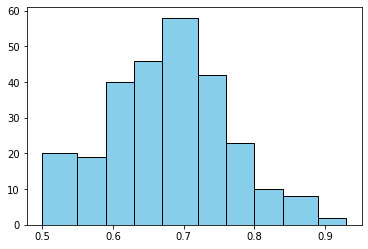

In [4]:

fig, ax = plt.subplots()
ax.bar(x=bin_edges[:-1], height=counts, width=np.diff(bin_edges), align='edge', fc='skyblue', ec='black')
plt.show()